<a href="https://colab.research.google.com/github/TruscaPetre/AAIT-Nosy-Missing-Labels/blob/main/tutorial%20colab%20missing%20labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Labels task 1

## Imports

In [1]:
import urllib
import shutil
import os
import time
import copy
import json

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, Dataset
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report

import itertools

In [2]:
task1_id = "1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd"

In [3]:
# replace here your ide &id=1iNTm3-9GSN2QjjITBi73ta73gDF_oacf"
# replace here your id 'https://docs.google.com/uc?export=download&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd'
# replace here your target name -O task1.tar.gz &&
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd" -O task1.tar.gz && rm -rf /tmp/cookies.txt


--2022-12-29 10:33:44--  https://docs.google.com/uc?export=download&confirm=t&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd
Resolving docs.google.com (docs.google.com)... 172.217.194.138, 172.217.194.100, 172.217.194.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d4p7ncfhbpvid67st0rdrvnabq4h22sq/1672309950000/08997952672865575084/*/1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd?e=download&uuid=4b46f450-ad75-4822-812f-97e083135689 [following]
--2022-12-29 10:33:45--  https://doc-0g-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d4p7ncfhbpvid67st0rdrvnabq4h22sq/1672309950000/08997952672865575084/*/1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd?e=download&uuid=4b46f450-ad75-4822-812f-97e083135689
Resolving doc-0g-8k-docs.googleusercontent.com (doc-0g-8k-docs.googleusercontent.com)... 142.251.10.1

In [167]:
%%capture
!mkdir data
!mv task1.tar.gz ./data
!tar -xzvf "/content/data/task1.tar.gz" -C "/content/data/"     #[run this cell to extract tar.gz files]
# this may take 12 seconds

In [166]:
# !rm -r /content/data/task1

### Set up logging


This experiment will take long, because there are many trianig periods involved and many changes going on in the data. There are some things that could be helpful to track along the way. So we set up a logger that will do this.

We are going to track: 
- all the hyperparameters for training.
- all the seeds for RNG
- the images that have been labeled at each iteration. 
- performance metrics ( we should see them increase through each iteration )

We are going to use a dictionary that will save all the data from each iteration of the experiment. Than save that dictionary into a json file for each iteration. 

There is a json file in the github repository with all the parameters for the first experiment.

Some comments about setting those parameters:
- The number of epochs is only 10 because according to the training only on the dataset with labeled data, this is the point where the validation set is reaching a saturation. In order to achieve the results faster from self-training, we should keep this number as small as possible.

In [118]:
experiment_info = {
    "iteration": 1,
    "image_processing":{
        "resize":224,
        "mean":[0.485, 0.456, 0.406],
        "std":[0.229, 0.224, 0.225],
    },
    "hyperparameters_data": {
        "batch_size":32,
        "shuffle_dataloader":True,
        "num_workers":4
    },
    "random_seeds":{
        "torch_seed":42,
        "numpy_seed":42,
        "cuda_seed":42,

    },
    "hyperparameters_training":{
        "learning_rate": 0.0001,
        "scheduler_step_size":7,
        "scheduler_gamma":0.1,
        "num_epochs":10, 
    },
    "total_unlabeled":26445,
}

In [16]:
# Save the dictionary to a file
with open("experiment_info.json", "w") as f:
    json.dump(experiment_info, f)

In [17]:
np.random.seed(experiment_info["random_seeds"]["numpy_seed"])
torch.manual_seed(experiment_info["random_seeds"]["torch_seed"])
torch.cuda.manual_seed_all(experiment_info["random_seeds"]["cuda_seed"])

In [18]:
# Load the experiment information from the JSON file
with open('experiment_info.json', 'r') as f:
    loaded_experiment_info = json.load(f)

display(loaded_experiment_info)

{'iteration': 1,
 'image_processing': {'resize': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'hyperparameters_data': {'batch_size': 32,
  'shuffle_dataloader': True,
  'num_workers': 4},
 'random_seeds': {'torch_seed': 42, 'numpy_seed': 42, 'cuda_seed': 42},
 'hyperparameters_training': {'learning_rate': 0.0001,
  'scheduler_step_size': 7,
  'scheduler_gamma': 0.1,
  'num_epochs': 10}}

### Mount drive

Each iteration of self-training takes about 1 hour on a GPU. So you might want to save and restart the training a few times. In order to restart the model where we where left of, we are connecting google drive and saving the model there.

In [19]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [20]:
with open('/gdrive/MyDrive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/MyDrive/foo.txt'

Hello Google Drive!

In [21]:
!rm '/gdrive/MyDrive/foo.txt'

## Theory about missing labels


- The classification problem can be tackled using semi-supervised learning methods. There are 3 propular approaches to address semi-supervised learning problems:
  - self training
  - co-training
  - graph-based models
- self training 
  - What is the process?
    - First train on labeled data
    - Make predictions on the untrained data
    - From those predictions, only extract those with high confidence and move them to the training data
    - Repeat the process until convergence or no high-confidence exmples left in the unlabeled set.
  - Disadvantage is that you can still generate incorrect predictions and the mistakes can be amplified in the subsequent trainings of the model.
- co-training
  - requires two feature representations associated with the dataset which serve as two different views of the data
  - The representations are dissimilar and conditionally independet, but they can provide complementary information about the data. 
  - We cannot do this for image classification because we have only visual representations of the data.
- graph-based models
  - labeled and unlabeled samples are represented as different nodes in a graph
  - the edges in this graph denote the similarity between nodes.
  - The assumption in this approach is that nodes with strong edges are likely to share the same label.
  - The algorithm to compute the labels is:
    - The unlabeled nodes can be labeled using random-walk over the graph. Based on the strength of the edges.
    - The walk ends when a labeled node is reached 
    - A probability that the random walker started at a particular unlabeled node given that it ended at a specific labeled node is computed. i.e. 2 poitns are similar if they have indistinguishabel starting points.


Reference: 
- https://www.kdnuggets.com/2019/11/tips-class-imbalance-missing-labels.html

## Training on labeled data

### Download model

In [22]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset

# the model has initially 1000 outputs
# print(model.classifier)
# > Sequential(
#   (0): Dropout(p=0.2)
#   (1): Linear(in_features=1280, out_features=1000, bias=True)
# )

model.classifier[1] = nn.Linear(1280, 100)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Prepare datasets

In [155]:
dir_data = 'data/task1/train_data/'
# Read the annotations file into a DataFrame
df = pd.read_csv(f'{dir_data}annotations.csv')

In [168]:
# Organize data for pytorch training ( only once )
# Define the base directory
base_dir = 'data/task1/labeled'

# Iterate over the rows in the DataFrame
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Extract the path and class from the row
    path = row['sample']
    label = row['label']
    
    # Create the directory for the class
    class_dir = f'{base_dir}/{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # Copy the file to the class directory
    shutil.copy(f"data/{path}", class_dir) 

#TODO: here I don't want to split the datasets into training and testing
# because I want to use all the training and to create a new dataset
# which will create labels for the untrained samples


100%|██████████| 23555/23555 [00:05<00:00, 4625.56it/s]


In [23]:
preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

data_dir = 'data/task1/labeled'
image_dataset = datasets.ImageFolder(data_dir, preprocess) 
dataloader  = torch.utils.data.DataLoader(
    image_dataset, 
    batch_size = experiment_info["hyperparameters_data"]["batch_size"],
    shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
    num_workers = experiment_info["hyperparameters_data"]["num_workers"]
    )

class_names = image_dataset.classes
dataset_size = len(image_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Start training

In [24]:
def train_loop(model, scheduler, optimizer, criterion, dataset_size, dataloader):
                     
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
    
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return model, epoch_loss, epoch_acc

def train_model(model, *args, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        model, epoch_loss, epoch_acc = train_loop(model, *args)
        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
# Setting hyperparameters

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(
    model.parameters(),
    lr=experiment_info["hyperparameters_training"]["learning_rate"],
    )

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
    gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
    )

In [26]:
model = train_model(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    dataset_size, 
                    dataloader, 
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])

Epoch 0/9
----------


100%|██████████| 737/737 [01:37<00:00,  7.57it/s]


Loss: 2.4110 Acc: 0.4470

Epoch 1/9
----------


100%|██████████| 737/737 [01:37<00:00,  7.57it/s]


Loss: 1.1668 Acc: 0.7053

Epoch 2/9
----------


100%|██████████| 737/737 [01:38<00:00,  7.45it/s]


Loss: 0.7535 Acc: 0.8063

Epoch 3/9
----------


100%|██████████| 737/737 [01:37<00:00,  7.58it/s]


Loss: 0.5016 Acc: 0.8720

Epoch 4/9
----------


100%|██████████| 737/737 [01:39<00:00,  7.44it/s]


Loss: 0.3168 Acc: 0.9249

Epoch 5/9
----------


100%|██████████| 737/737 [01:37<00:00,  7.57it/s]


Loss: 0.2043 Acc: 0.9547

Epoch 6/9
----------


100%|██████████| 737/737 [01:37<00:00,  7.58it/s]


Loss: 0.1287 Acc: 0.9745

Epoch 7/9
----------


100%|██████████| 737/737 [01:39<00:00,  7.44it/s]


Loss: 0.0617 Acc: 0.9919

Epoch 8/9
----------


100%|██████████| 737/737 [01:37<00:00,  7.58it/s]


Loss: 0.0408 Acc: 0.9974

Epoch 9/9
----------


100%|██████████| 737/737 [01:37<00:00,  7.59it/s]

Loss: 0.0331 Acc: 0.9987

Training complete in 16m 18s
Best val Acc: 0.998684


In [27]:
import torch

# Save the model
torch.save(model.state_dict(), '/gdrive/MyDrive/checkpoints/missing_labels/model_it_1.pt')

## Predict new set of labels

In [169]:
# Set the source and destination directories
source_dir = 'data/task1/train_data/images/unlabeled'
destination_dir = 'data/task1/train_data/images/unlabeled/0'
os.makedirs(destination_dir, exist_ok=True)

In [170]:
# Iterate over all the files in the source directory
for file in tqdm(os.listdir(source_dir)):
    if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
        # Construct the source and destination paths
        src_path = os.path.join(source_dir, file)
        dst_path = os.path.join(destination_dir, file)
        # Move the file
        shutil.move(src_path, dst_path) 

100%|██████████| 26446/26446 [00:00<00:00, 30271.43it/s]


In [171]:
# sanity check to see that all images have been moved to unlabeled/0 dir
len(os.listdir(destination_dir)) # 26445

26445

In [66]:
# Create a new dataloader with unlabeled data.
# Dataset folder is a subclass of ImageFolder 
# Which will allow us to return also the path of the image
# because we need it to know which images should be moved 

from torchvision.datasets import DatasetFolder

data_dir = 'data/task1/train_data/images/unlabeled'
image_dataset_unlabeled = datasets.ImageFolder(root=data_dir, transform=preprocess)

dataloader_unlabeled  = torch.utils.data.DataLoader(
    image_dataset_unlabeled, 
    batch_size = 1, 
    )

dataset_size = len(image_dataset_unlabeled)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [92]:
predicted_labels = {
    "path":[],
    "confidence":[],
    "label":[]
}

# Each epoch has a training and validation phase 
model.eval()   # Set model to evaluate mode 

# Iterate over data.
img_path_generator = ((image, path) for (path,_) , (image, _) in zip(image_dataset_unlabeled.samples, dataloader_unlabeled))

for inputs, path in tqdm(img_path_generator, total=dataset_size):
    inputs = inputs.to(device)

    # forward
    with torch.set_grad_enabled(False): # we don't want to train
        outputs = model(inputs)
        confidence, preds = torch.max(outputs, 1) 
    predicted_labels["path"].append(path) 
    predicted_labels["confidence"].append(confidence.item())
    predicted_labels["label"].append(preds.item())


    

100%|██████████| 26445/26445 [03:43<00:00, 118.07it/s]


### Visualize the predictions

Text(0.5, 1.0, 'Distribution of Confidence Scores')

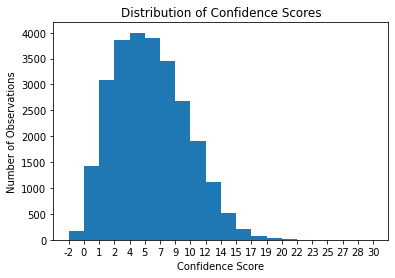

In [172]:
# Plot a distribution of the convidence scores. To find a threshold
counts, bins, patches = plt.hist(predicted_labels["confidence"], bins = 20)

# Set x-axis label
plt.xlabel('Confidence Score')
plt.xticks(bins, bins.astype(int))
# Set y-axis label
plt.ylabel('Number of Observations')

# Set plot title
plt.title('Distribution of Confidence Scores')

In [173]:
print(bins)

[-2.2711072  -0.63155334  1.00800052  2.64755437  4.28710823  5.92666209
  7.56621594  9.2057698  10.84532366 12.48487751 14.12443137 15.76398523
 17.40353909 19.04309294 20.6826468  22.32220066 23.96175451 25.60130837
 27.24086223 28.88041608 30.51996994]


In [174]:
# Select the top X bins but not more than 10% of the unlabeled dataset
# to move into the labeled dataset
top10 = experiment_info["total_unlabeled"]*0.1
if sum(counts)>top10:
    for x in range(20):
        top10-=counts[-x-1]
        if top10 < 0:
            break
    n_keep = int(sum(counts[-x:]))
else:
    n_keep = int(sum(counts))
print(n_keep)

1962


In [134]:
# Sort the confidence scores in descending order
sorted_confidences = np.sort(predicted_labels["confidence"])[::-1]

# Keep the first n_keep scores
top_confidences = sorted_confidences[:n_keep]

# Find the indices of the top confidences in the original list of confidences
top_confidence_indices = [i for i, c in enumerate(predicted_labels["confidence"]) if c in top_confidences]

# Use the indices to select the corresponding paths and labels
top_confidences = [predicted_labels["confidence"][i] for i in top_confidence_indices]
top_paths = [predicted_labels["path"][i] for i in top_confidence_indices]
top_labels = [predicted_labels["label"][i] for i in top_confidence_indices]

In [135]:
iteration_predictions = {
    "path":top_paths,
    "confidence":top_confidences,
    "label":top_labels
}

In [175]:
# Load the experiment information from the JSON file
num_iteration = 0
# Save the experiment information to a JSON file
with open(f'iteration_{num_iteration}_images.json', 'w') as f:
    json.dump(iteration_predictions, f)

In [176]:
# Load the experiment information from the JSON file
with open(f'iteration_{num_iteration}_images.json', 'r') as f:
    iteration_predictions = json.load(f)

df_labeled = pd.DataFrame(iteration_predictions)


In [177]:
# Move the images above the trashold in the dataset
# Iterate through the selected rows and move the images
for index, row in tqdm(df_labeled.iterrows(),total=n_keep):
    parts = row['path'].split(".")
    parts[0]+=f"_it_{num_iteration}"
    new_name = ".".join(parts).split('/')[-1]
    shutil.copy(row['path'], f"data/task1/labeled/{row['label']}/{new_name}")

100%|██████████| 1962/1962 [00:00<00:00, 5296.94it/s]


# Repeat the following iterations of self-training

In [178]:
def create_dataset():
    data_dir = 'data/task1/labeled'
    preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

    image_dataset = datasets.ImageFolder(data_dir, preprocess) 
    dataloader  = torch.utils.data.DataLoader(
        image_dataset, 
        batch_size = experiment_info["hyperparameters_data"]["batch_size"],
        shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
        num_workers = experiment_info["hyperparameters_data"]["num_workers"]
        )

    class_names = image_dataset.classes
    dataset_size = len(image_dataset)
    return class_names, dataset_size, dataloader, image_dataset

for num_iteration in range(1,10):
    class_names, dataset_size, dataloader, image_dataset = create_dataset()
 
    print(num_iteration)

1
2
3
4
5
6
7
8
9


In [ ]:
# TODO: restart the training on the new dataset
# TODO: put all the previous 3 steps in a loop 

In [ ]:
# k-fold cross-validation, 
# ensemble methods, 
# or importance sampling

## Test the model on the new dataset 

In [ ]:

# This will shuffle the images in the dataset 
# before they are returned to the data loader,
# which should help ensure that the validation and training sets
# are more balanced.
class ShuffledImageFolder(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = torch.randperm(len(dataset))

    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.dataset)

data_dir = 'data/task1/labeled'
image_dataset_unshuffled = datasets.ImageFolder(data_dir, preprocess)
image_dataset = ShuffledImageFolder(image_dataset_unshuffled)

# print(image_datasets)
# We don't want to create a single dataset because we want to have a dataset for evaluation also
# dataloader  = torch.utils.data.DataLoader(image_dataset, batch_size = 4, shuffle = True, num_workers = 4)

# split data into train and val

dataset_size = len(image_dataset)
print(dataset_size)
split = int(dataset_size*0.8)
train_size = split
print(train_size)
val_size = dataset_size - split
print(val_size)
assert val_size+train_size == dataset_size
class_names = image_dataset.dataset.classes

# Create a sampler for the training set
train_sampler = SubsetRandomSampler(range(split))

# Create a sampler for the valuation set
val_sampler = SubsetRandomSampler(range(split, dataset_size))

# Create DataLoaders for the training and valuation sets
train_dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=32, sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=32, sampler=val_sampler, shuffle=False)
dataloaders = {
    "train":train_dataloader,
    "val":val_dataloader,
}
dataset_sizes = {
    "train":train_size,
    "val":val_size,
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Setting hyperparameters

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)